## Data preparation for running my model 

- We handled the missing values and formating of age, weight and race to make it more suitable for the model
- We dropped irrelevant and highly missing values variables, we will also drop encounter id and patient number since it do not contribute significantly in anything for the model 
- Categorical values will be further one-hot encoding into numerical format
- Numerical will be standarized for zero mean and unit variance

In [2]:
import pandas as pd

# Load the train and test sets prepared earlier
diabetes_train = pd.read_parquet("data/02_train.parquet")
diabetes_test = pd.read_parquet("data/02_test.parquet")

print("Train data shape:", diabetes_train.shape)
print("Test data shape:", diabetes_test.shape)


Train data shape: (81410, 49)
Test data shape: (20353, 48)


In [3]:
import nbimporter
from data_eval import map_age_category

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_age_group=True, add_race_group=True):
        self.add_age_group = add_age_group
        self.add_race_group = add_race_group

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = X.copy()
        if self.add_age_group:
            # Add new feature: age group based on 'age' column
            X['age_group'] = X['age'].apply(map_age_category)
            X = X.drop(columns=['age'], errors='ignore')

        if self.add_race_group:
            # Add new feature: race group based on 'race' column
            X['race_group'] = X['race'].replace('?', 'Other')
            X = X.drop(columns=['race'], errors='ignore')

        return X

feature_adder_pipeline = Pipeline([
    ("feature_adder", FeatureAdder(add_age_group=True, add_race_group=True))
])

## Pipeline for categorical attributes 

- for a better understanding and visualization for the model categorical values were preprocessed into binary coding assigning new columns for multiple categorical variables. 


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Create a pipeline to handle the categorical features
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")), # Other options for categorical features could be 'constant' or 'drop'
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

In [6]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler
num_selector = make_column_selector(dtype_include=["int", "float"])      # picks Age, Fare, ...
cat_selector = make_column_selector(dtype_include=["object", "category", "bool"])
drop_columns = ["patient_nbr", "encounter_id", "payer_code",
                "max_glu_serum",
                "A1Cresult"]

drop_pipelines = ColumnTransformer(
    transformers = [
        ("drop", "drop", drop_columns)
    ],
    remainder="passthrough"  # Keep all other columns not specified in the transformers
)

transformer_pipeline = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), num_selector),
        ("cat", cat_pipeline, cat_selector),
    ],
    remainder="passthrough"
)

# Combine all preprocessing steps into a single pipeline
full_preprocess_pipeline = Pipeline([
    ("feature_adder", feature_adder_pipeline),
    ("feature_remover", drop_pipelines),
    ("transformer", transformer_pipeline)
])


In [7]:
print(full_preprocess_pipeline)

Pipeline(steps=[('feature_adder',
                 Pipeline(steps=[('feature_adder', FeatureAdder())])),
                ('feature_remover',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['patient_nbr',
                                                   'encounter_id', 'payer_code',
                                                   'max_glu_serum',
                                                   'A1Cresult'])])),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17b1a4820>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
              

## Model Set up

### Choosing the targeted value:

- The ML model will require its inputs and we needed to choose a target variable for the model prediction, in this case I have decided to allow the model to predict the time a patient will be in the hospital, represented in the database as time_in_hospital 

- It can be important since when having a patient entering under the same conditions doctors and nurses can have an approximation of the days the patience will be within the hospital, plus it is important from an economical point of view for the expenses associated to the stay either for the member or the insurance company covering the treatment.

In [27]:

# Extract the target variable and drop it from the training and test data
y_train = diabetes_train["diabetesMed"]  # Target variable
X_train = diabetes_train.drop(columns=["diabetesMed"])  # Drop the target variable from the training data

y_test = diabetes_test["diabetesMed"]  # Target variable for the test set
X_test = diabetes_test.drop(columns=["diabetesMed"])  # Drop the target variable from the test data


In [9]:
from sklearn import set_config

set_config(transform_output="pandas")

X_train = full_preprocess_pipeline.fit_transform(X_train)  # Apply the transformations to the training set
# Get the column names of the transformed DataFrame, split by '__', and extract the last entries
X_train.columns = X_train.columns.str.split("__").str[-1]  # Flatten the column names
X_train.columns = [col.replace("[", "_").replace("]", "_").replace("<", "_")  for col in X_train.columns]  # Replace spaces with underscores in column names


In [10]:
X_test = full_preprocess_pipeline.transform(X_test)
X_test.columns = [col.replace("[", "_").replace("]", "_").replace("<", "_") for col in X_test.columns]

## Training Model Selection

Now I need to select our training model 
- From all the possible candidates form classification algorithms I need to select the most suitable for my dataset
- See how they fit the training data and evaluate their performace using cross-validation
- Compare their mean and spread using boxplots to compare stability and accuracy and select the best performing method 

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np

#Cross-validation function 
def evaluate_model(model, X, y, scoring="accuracy", cv=5, n_repeats=10):
    '''
    Cross-validation.
    Parameters:
    - model: The machine learning model to evaluate.
    - X: Features for training.
    - y: Target variable for training.
    - scoring: Scoring metric to use (default is accuracy).
    - cv: Number of cross-validation folds (default is 5).
    - n_repeats: Number of times to repeat the cross-validation (default is 10).
    Returns:
    - scores: Cross-validation scores.
    '''
    all_scores = []
    # Using RepeatedStratifiedKFold to ensure that each fold has the same proportion of classes
    # and to repeat the cross-validation process multiple times

    tskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=n_repeats, random_state=42)
    for train_index, test_index in tskf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        score = accuracy_score(y_test_fold, y_pred)
        all_scores.append(score)

    return np.array(all_scores)


In [12]:


# Define the models to evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode labels to ensure consistency across folds
le = LabelEncoder()
#y_train_enc = le.fit_transform(y_train)
y_train_enc = pd.Series(le.fit_transform(y_train), index=y_train.index)


# Define a list of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Neural Network": MLPClassifier(
        random_state=42, 
        max_iter=5000, 
        hidden_layer_sizes=(20, 10), 
        activation='relu', 
        solver='adam'
    ),
    "KNN Classifier": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Evaluate each model using cross-validation
model_scores = {}
for model_name, model in models.items():
    scores = evaluate_model(model, X_train, y_train_enc, scoring="accuracy", cv=5, n_repeats=10)
    model_scores[model_name] = scores

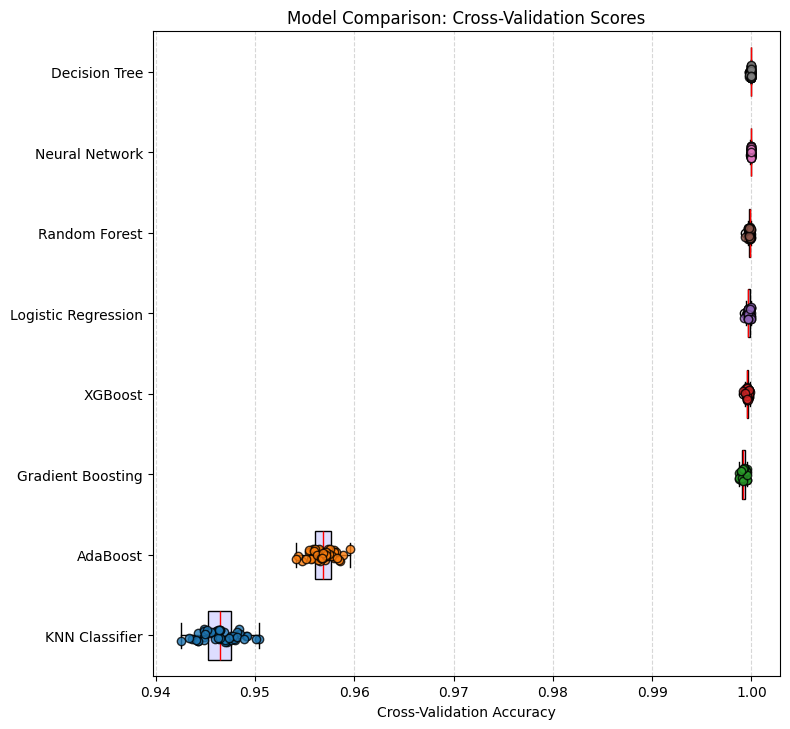

In [20]:
# Plot the cross-validation scores for each model as separate points and overlay those with a box plot
import matplotlib.pyplot as plt

def plot_model_scores(model_scores):
    """
    Plot the cross-validation scores for each model as a box plot with individual points overlaid.
    Args:
        model_scores (dict): Dictionary with model names as keys and cross-validation scores as values.
    """
    data = list(model_scores.values())
    names = list(model_scores.keys())
    # order by mean score
    mean_scores = [scores.mean() for scores in data]
    sorted_indices = np.argsort(mean_scores)
    names = [names[i] for i in sorted_indices]
    data = [data[i] for i in sorted_indices]
    positions = np.arange(len(names))  # Recalculate positions after sorting

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 0.8 * len(names) + 1))

    # Boxplots (horizontal so keys are on the y‑axis)
    box = ax.boxplot(
        data,
        vert=False,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor="#ddddff", edgecolor="black"),
        medianprops=dict(color="red")
    )

    # Scatter individual points with a little jitter
    for y_pos, vals in zip(positions, data):
        jitter = np.random.uniform(-0.08, 0.08, size=len(vals))
        ax.scatter(vals, y_pos + jitter, alpha=0.8, edgecolor="k", zorder=3)

    # Aesthetics
    ax.set_yticks(positions)
    ax.set_yticklabels(names)
    ax.set_xlabel("Score")
    ax.set_title("Scores per Group - individual points overlaid on boxplots")
    ax.grid(axis="x", linestyle="--", alpha=0.5)

    plt.xlabel("Cross-Validation Accuracy")
    plt.title("Model Comparison: Cross-Validation Scores")
    plt.tight_layout()
    plt.show()

plot_model_scores(model_scores)

We can see here that the models that performed the worse with our current dataset were Adaboost and KNN Classifier for this reason we have choosen to filter them out to be able to evaluate better the results.

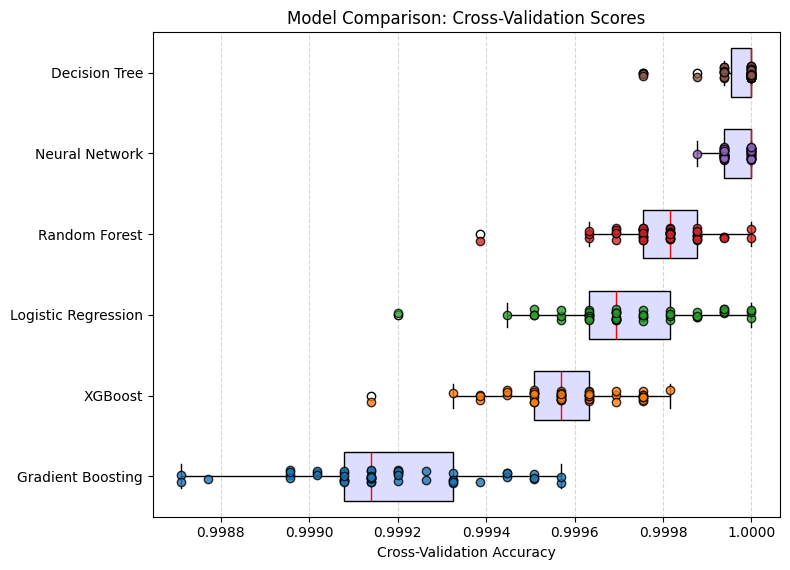

In [23]:
# Filter out AdaBoost and KNN
filtered_model_scores = {k: v for k, v in model_scores.items() if 'AdaBoost' not in k and 'KNN' not in k}

# Plot the filtered results
plot_model_scores(filtered_model_scores)


In this case just by eye inspection I will go ahead with Random Forest since the Decision Tree and Neural Network look like they are overfitted, we can evaluate 